<a href="https://colab.research.google.com/github/CodyBurker/W266_Group_Project/blob/CodyCNNBase/CodyCNNAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [2]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk

In [3]:
!git clone https://github.com/CodyBurker/W266_Group_Project

Cloning into 'W266_Group_Project'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 10), reused 22 (delta 2), pack-reused 0
Unpacking objects: 100% (35/35), done.
Checking out files: 100% (9/9), done.


In [4]:
def read_in_data(path="W266_Group_Project/"):
    import pandas as pd
    X_train = pd.read_csv(path + "x_train_sampled_yelp_data.csv")
    y_train = pd.read_csv(path + "y_train_sampled_yelp_data.csv")
    X_test = pd.read_csv(path + "x_test_sampled_yelp_data.csv")
    y_test = pd.read_csv(path + "y_test_sampled_yelp_data.csv")
    return X_train, X_test, y_train, y_test

In [5]:
 X_train, X_test, y_train, y_test = read_in_data()

https://towardsdev.com/sentiment-analysis-with-cnn-using-keras-c4debff57fc5?gi=708b4ef40e2f

Encode text and pad it.

In [6]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])


In [8]:
X_train['encoded'] = tokenizer.texts_to_sequences(X_train['text'])
X_test['encoded'] = tokenizer.texts_to_sequences(X_test['text'])

(array([47936., 21142.,  6699.,  2360.,   947.,   441.,   202.,   134.,
           90.,    49.]),
 array([   0.,  101.,  202.,  303.,  404.,  505.,  606.,  707.,  808.,
         909., 1010.]),
 <a list of 10 Patch objects>)

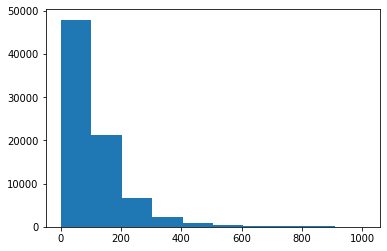

In [16]:
import matplotlib.pyplot as plt
plt.hist(X_train['encoded'].apply(len))

In [17]:
# Hyper parameters to tune later: maxlen, padding
sentence_len = 200
X_train_encoded =  pad_sequences(X_train['encoded'], maxlen=sentence_len, padding='post')
X_test_encoded = pad_sequences(X_test['encoded'], maxlen=sentence_len, padding='post')
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(80000, 200)
(20000, 200)


Create model

In [18]:
from keras import Sequential
from keras.layers import Dense, Embedding, Activation, Dropout
from keras.layers import  MaxPool1D, GlobalMaxPool1D, Conv1D
vocab_size = len(tokenizer.word_counts)

model = Sequential()
model.add(Embedding(vocab_size,300, input_length = sentence_len))
model.add(Conv1D(64,8,activation="relu"))
model.add(MaxPool1D(2))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16,activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(3,activation='softmax'))
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 300)          23360400  
                                                                 
 conv1d_3 (Conv1D)           (None, 193, 64)           153664    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 96, 64)           0         
 1D)                                                             
                                                                 
 dense_9 (Dense)             (None, 96, 32)            2080      
                                                                 
 dropout_3 (Dropout)         (None, 96, 32)            0         
                                                                 
 dense_10 (Dense)            (None, 96, 16)            528       
                                                      

In [12]:
# model.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [ ]:
# model.fit(X_train_encoded,y_train, epochs=10, validation_data = [X_test_encoded, y_test])

In [ ]:
# Save model
# from google.colab import drive
# drive.mount('/content/drive')
# model.save("/content/drive/MyDrive/Code Repos/YelpCNN")
# Inspiration: https://chercher.tech/nlp/convolutional-neural-networks-cnns-for-nlp

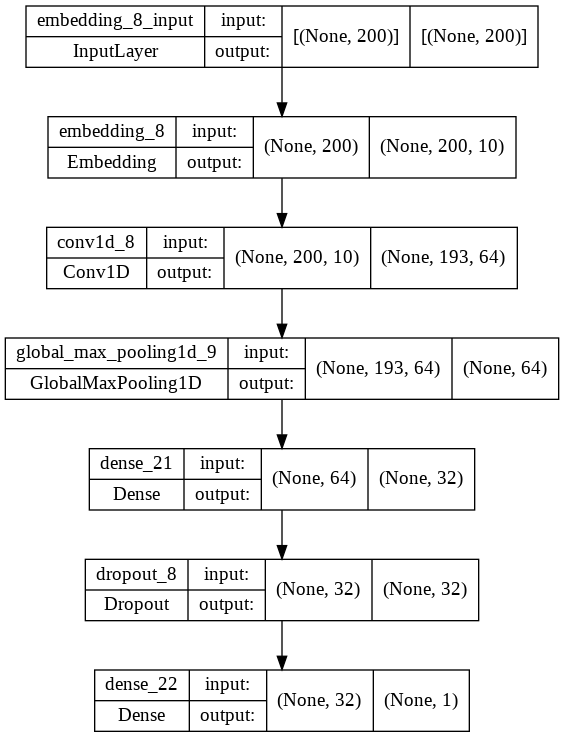

In [34]:
from keras.layers.pooling import GlobalMaxPool1D
# New model architecture
model2 = Sequential()
model2.add(Embedding(vocab_size,10, input_length = sentence_len))
model2.add(Conv1D(64,8,activation="relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(1,activation='relu'))
from keras.utils.vis_utils import plot_model
model2.compile(optimizer='adam', loss='mse',metrics=['mse'])
plot_model(model2,show_shapes=True)


In [68]:
model2.fit(X_train_encoded,y_train,
           epochs=20,
           batch_size=100, 
           validation_data = [X_test_encoded, y_test])

Epoch 1/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2969 - mse: 0.2969 - val_loss: 0.6811 - val_mse: 0.6811
Epoch 2/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2854 - mse: 0.2854 - val_loss: 0.6860 - val_mse: 0.6860
Epoch 3/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2739 - mse: 0.2739 - val_loss: 0.6887 - val_mse: 0.6887
Epoch 4/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2605 - mse: 0.2605 - val_loss: 0.6843 - val_mse: 0.6843
Epoch 5/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2509 - mse: 0.2509 - val_loss: 0.6840 - val_mse: 0.6840
Epoch 6/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2444 - mse: 0.2444 - val_loss: 0.6874 - val_mse: 0.6874
Epoch 7/20
800/800 [==============================] - 3s 3ms/step - loss: 0.2427 - mse: 0.2427 - val_loss: 0.6933 - val_mse: 0.6933
Epoch 8/20
800/800 [==============================] - 3s 3ms/step - loss: 0.

Diangose errors. Looks like there might be some overfitting. Let's look at the 10 worst predictions:

In [69]:
predictions_raw = model2.predict(X_test_encoded)


In [97]:
un_tokenized = tokenizer.sequences_to_texts(X_test_encoded)

In [100]:
import numpy as np
predictions = pd.DataFrame({
    "text":un_tokenized,
    "true":y_test['stars'],
    "predicted":[round(x[0],1) for x in predictions_raw]
    })
predictions['error'] = np.abs(predictions['true'] - predictions['predicted'])
predictions_sorted = predictions.sort_values(by='error',ascending=False)
for i in range(len(predictions_sorted.head(10))):
  print("True rating:", predictions_sorted.iloc[i]['true'])
  print("Predicted rating:", predictions_sorted.iloc[i]['predicted'])
  print("Text:", predictions_sorted.iloc[i]['text'])
  print("")

True rating: 5.0
Predicted rating: 0.2
Text: lmao all you dumbass people talking about this isn't authentic or i heard this was a taste of true mexican food no shit its a fast food chain lmfao idiots go to a damn restaurant this is fast food version of mexican food just like casa ole or taco cabana it's fast food workers just like at mcdonald's or taco bell lmfao these poor people are just beating shit that was sent in a box they don't hire real authentic mexican cooks hahah naw it's the dude in the apartment next you that just lost his job and needs to pay for his cigarettes they give no fucks other than if their pay check was deposited stop being such cheap assholes and go out if yo i want the authentic mexican taste lmfao this is austin texas one of the most expensive cities hahahah so get your priorities straight if you can't afford 10 bucks for half ass fajita tacos then you need to stay home and eat noodles cause your fucking broke

True rating: 1.0
Predicted rating: 5.2
Text: i 

In [114]:
import plotly.express as px
predictions['text_short'] = [x[0:100] + '...' for x in predictions['text']]
fig = px.scatter(predictions, x='true',y='predicted', hover_data=['text_short'],trendline='ols',opacity=0.05)
fig.show()